In [60]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("ConvertJSON").getOrCreate()

# Define the JSON object as a string
json_string = '''
{
  "http_req": "https://www.bbc.com/",
  "request_id": "D696FCD3475A4A7857B3CF45587D5C04",
  "top_level_url": "bbc.com",
  "frame_url": "https://www.bbc.com/",
  "resource_type": "Document",
  "header": {
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36",
    "sec-ch-ua": "\\"Chromium\\";v=\\"112\\", \\"Google Chrome\\";v=\\"112\\", \\"Not:A-Brand\\";v=\\"99\\"",
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": "\\"Linux\\""
  },
  "timestamp": 1663.69433,
  "frameId": "620132D55C9DAFDC5EE2FAA94C39C73E",
  "call_stack": {
    "type": "other"
  }
}
{"http_req":"https://static.files.bbci.co.uk/orbit/96bf4601db7472462d3464c8eecd5af6/css/orbit-v5-ltr.min.css","request_id":"3633.2","top_level_url":"bbc.com","frame_url":"https://www.bbc.com/","resource_type":"Stylesheet","header":{"Referer":"https://www.bbc.com/","User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36","sec-ch-ua":"\"Chromium\";v=\"112\", \"Google Chrome\";v=\"112\", \"Not:A-Brand\";v=\"99\"","sec-ch-ua-mobile":"?0","sec-ch-ua-platform":"\"Linux\""},"timestamp":1664.020703,"frameId":"620132D55C9DAFDC5EE2FAA94C39C73E","call_stack":{"columnNumber":126,"lineNumber":47,"type":"parser","url":"https://www.bbc.com/"}}
'''

# Convert the JSON string to a DataFrame
df = spark.read.json(spark.sparkContext.parallelize([json_string]))

# Show the DataFrame
df.show()


+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------+-------------+
|call_stack|             frameId|           frame_url|              header|            http_req|          request_id|resource_type| timestamp|top_level_url|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------+-------------+
|   [other]|620132D55C9DAFDC5...|https://www.bbc.com/|[1, Mozilla/5.0 (...|https://www.bbc.com/|D696FCD3475A4A785...|     Document|1663.69433|      bbc.com|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------+-------------+



In [66]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, MapType, LongType

# Define the schema of the JSON objects
schema = StructType([
    StructField("http_req", StringType()),
    StructField("request_id", StringType()),
    StructField("top_level_url", StringType()),
    StructField("frame_url", StringType()),
    StructField("resource_type", StringType()),
    StructField("header", MapType(StringType(), StringType())),
    StructField("timestamp", DoubleType()),
    StructField("frameId", StringType()),
    StructField("call_stack", StructType([
        StructField("columnNumber", LongType()),
        StructField("lineNumber", LongType()),
        StructField("type", StringType()),
        StructField("url", StringType())
    ]))
])

# Read the file into a DataFrame
df = spark.read.json("request.json", schema=schema)

# Select the columns
parsed_df = df.select(col("http_req"), col("request_id"), col("top_level_url"), col("frame_url"), col("resource_type"), col("header"), col("timestamp"), col("frameId"), col("call_stack"))


In [67]:
# Convert the timestamp column to timestamp type
parsed_df = parsed_df.withColumn("timestamp", from_unixtime(col("timestamp")))

# Group the data by 60 second windows and count the objects
windowed_df = parsed_df.groupBy(window(col("timestamp"), "1 seconds"), col("top_level_url")) \
               .agg(count("*").alias("count"))

# Show the result
windowed_df.show()

+--------------------+-------------+-----+
|              window|top_level_url|count|
+--------------------+-------------+-----+
|[1970-01-01 00:27...|      bbc.com|   18|
|[1970-01-01 00:27...|      bbc.com|   27|
|[1970-01-01 00:27...|      bbc.com|   12|
|[1970-01-01 00:27...|      bbc.com|   14|
|[1970-01-01 00:27...|      bbc.com|    9|
|[1970-01-01 00:27...|      bbc.com|    1|
|[1970-01-01 00:27...|      bbc.com|    1|
|[1970-01-01 00:27...|      bbc.com|    4|
|[1970-01-01 00:27...|      bbc.com|    1|
|[1970-01-01 00:27...|      bbc.com|   35|
|[1970-01-01 00:27...|      bbc.com|    1|
+--------------------+-------------+-----+



In [68]:
import matplotlib.pyplot as plt

def plot_windowed_df(windowed_df):
    # Extract the data to plot
    window_starts = [w.start for w in windowed_df.select("window.start").collect()]
    counts = windowed_df.select("count").collect()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(window_starts, counts, marker="o")
    
    # Format the plot
    ax.set_title("Count of requests per 60 second window")
    ax.set_xlabel("Window start time")
    ax.set_ylabel("Count of requests")
    ax.xaxis.set_tick_params(rotation=45)
    
    plt.show()


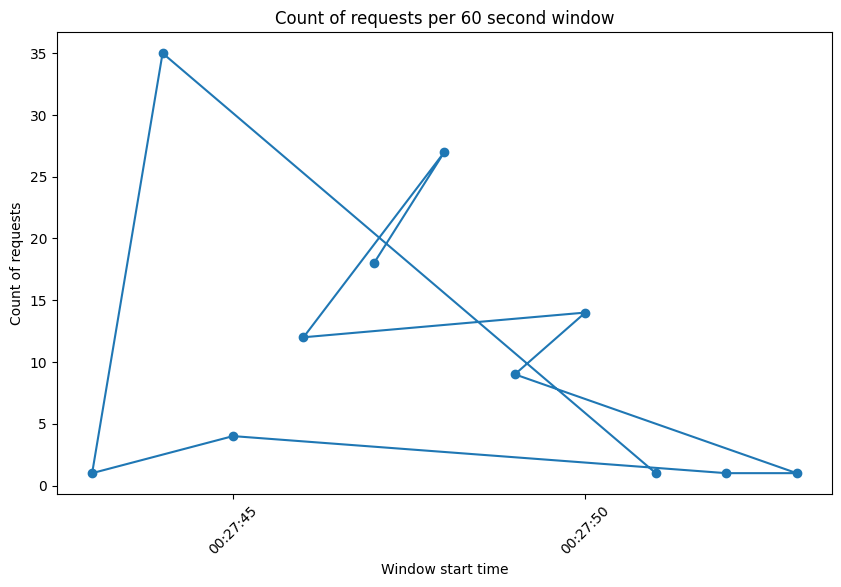

In [69]:
plot_windowed_df(windowed_df)

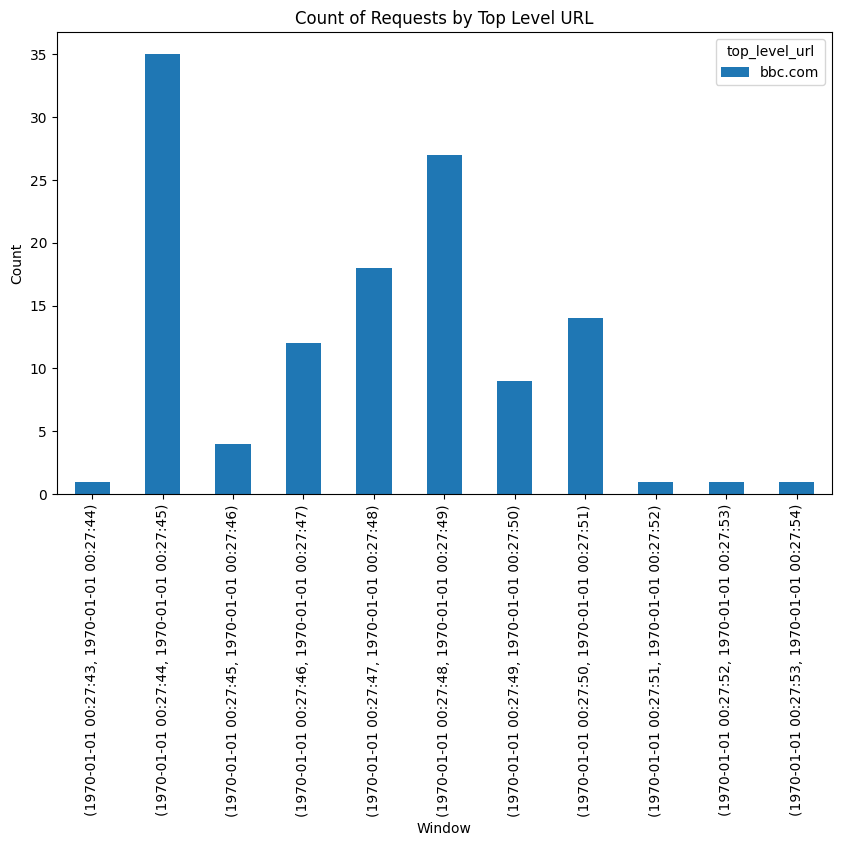

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the windowed_df to a Pandas DataFrame for plotting
pdf = windowed_df.toPandas()

# Create a bar plot of the counts by top_level_url for each window
fig, ax = plt.subplots(figsize=(10,6))
pdf.pivot(index='window', columns='top_level_url', values='count').plot(kind='bar', ax=ax)

# Set plot labels and title
ax.set_xlabel('Window')
ax.set_ylabel('Count')
ax.set_title('Count of Requests by Top Level URL')

# Show the plot
plt.show()


In [79]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, MapType, LongType
import os

# Define the schema of the JSON objects
schema = StructType([
    StructField("http_req", StringType()),
    StructField("request_id", StringType()),
    StructField("top_level_url", StringType()),
    StructField("frame_url", StringType()),
    StructField("resource_type", StringType()),
    StructField("header", MapType(StringType(), StringType())),
    StructField("timestamp", DoubleType()),
    StructField("frameId", StringType()),
    StructField("call_stack", StructType([
        StructField("columnNumber", LongType()),
        StructField("lineNumber", LongType()),
        StructField("type", StringType()),
        StructField("url", StringType())
    ]))
])

# Read the files into a DataFrame
path = "output"
json_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if f.endswith('.json')]
df = spark.read.json(json_files, schema=schema)

# Select the columns
parsed_df = df.select(col("http_req"), col("request_id"), col("top_level_url"), col("frame_url"), col("resource_type"), col("header"), col("timestamp"), col("frameId"), col("call_stack"))

# Convert the timestamp column to timestamp type
parsed_df = parsed_df.withColumn("timestamp", from_unixtime(col("timestamp")))

# Group the data by 60 second windows and count the objects
windowed_df = parsed_df.groupBy(window(col("timestamp"), "1 seconds"), col("top_level_url")) \
               .agg(count("*").alias("count"))

# Show the result
windowed_df.show(windowed_df.count(),truncate=False)


+------------------------------------------+--------------------+-----+
|window                                    |top_level_url       |count|
+------------------------------------------+--------------------+-----+
|[1970-01-01 00:27:21, 1970-01-01 00:27:22]|bloomberg.com       |112  |
|[1970-01-01 00:27:59, 1970-01-01 00:28:00]|thestartmagazine.com|7    |
|[1970-01-01 00:27:34, 1970-01-01 00:27:35]|bloomberg.com       |50   |
|[1970-01-01 00:27:26, 1970-01-01 00:27:27]|bloomberg.com       |60   |
|[1970-01-01 00:28:00, 1970-01-01 00:28:01]|thestartmagazine.com|1    |
|[1970-01-01 00:27:30, 1970-01-01 00:27:31]|bloomberg.com       |12   |
|[1970-01-01 00:27:37, 1970-01-01 00:27:38]|bloomberg.com       |4    |
|[1970-01-01 00:27:22, 1970-01-01 00:27:23]|bloomberg.com       |12   |
|[1970-01-01 00:28:01, 1970-01-01 00:28:02]|thestartmagazine.com|31   |
|[1970-01-01 00:27:35, 1970-01-01 00:27:36]|bloomberg.com       |18   |
|[1970-01-01 00:27:39, 1970-01-01 00:27:40]|bloomberg.com       

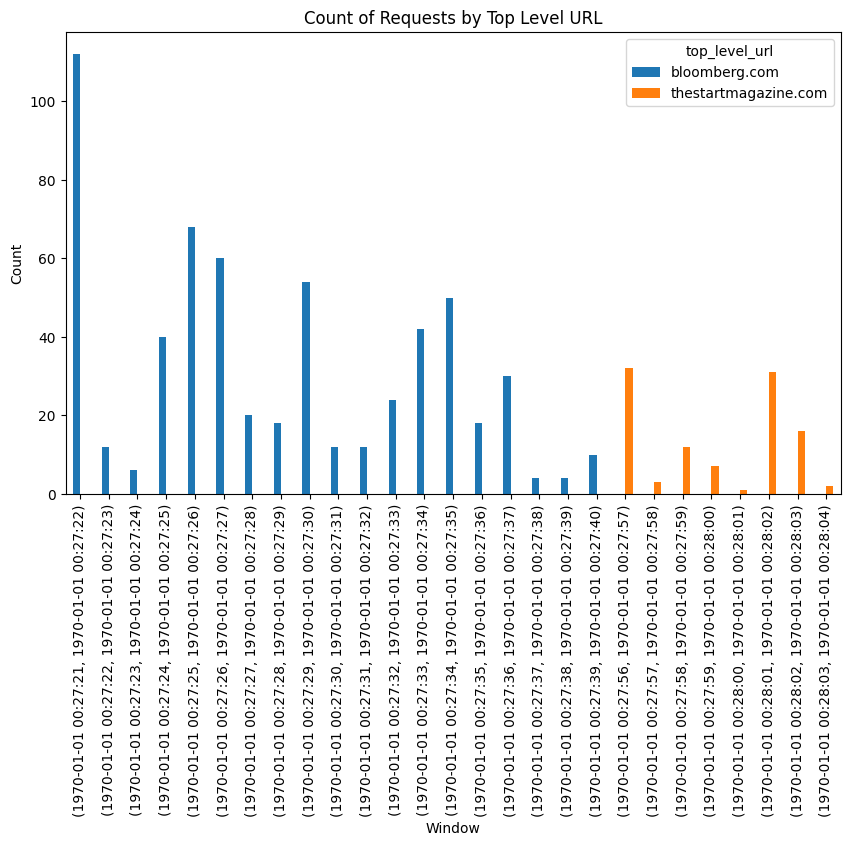

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the windowed_df to a Pandas DataFrame for plotting
pdf = windowed_df.toPandas()

# Create a bar plot of the counts by top_level_url for each window
fig, ax = plt.subplots(figsize=(10,6))
pdf.pivot(index='window', columns='top_level_url', values='count').plot(kind='bar', ax=ax)

# Set plot labels and title
ax.set_xlabel('Window')
ax.set_ylabel('Count')
ax.set_title('Count of Requests by Top Level URL')

# Show the plot
plt.show()
